## colon_cancer.csv 활용

In [1]:
pip install lifelines scikit-survival pycox torchtuples shap optuna

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### LR, Dropoutrate, Activation function에 대해서 Optunity 최적화 [64,32,32,32,32,16]

* Node = [64,32,32,16] **(hiddenlayer수:4)**

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/생존분석 논문자료/graduation/data/origin_colon_cancer.csv')

tx_cols = [col for col in df.columns if col.startswith('tx_')]
print(tx_cols)

['tx_00000', 'tx_00100', 'tx_01000', 'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100']


* Time Grid 수정이전

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import optuna

from sklearn.model_selection import RepeatedKFold
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score
)
import torchtuples as tt
from pycox.models import CoxPH
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------
# 데이터 로드 및 전처리
# -------------------
df = pd.read_csv(
    '/content/drive/MyDrive/생존분석 논문자료/graduation/data/origin_colon_cancer.csv')

# treatment type about colon cancer patients(data reference ----> "/content/drive/MyDrive/생존분석 논문자료/graduation/data/origin_colon_cancer.csv")
# ['tx_00000', 'tx_00100', 'tx_01000', 'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100']

feature_cols = ['age_scaled','tx_00000', 'tx_00100', 'tx_01000', 'tx_10000',
                'tx_10100', 'tx_01100', 'tx_11000','tx_11100',
                'Localized','Regional', 'Distant', 'sex']
time_col  = 'stime'
event_col = 'event_inc'

# sex가 object면 코드화
if df['sex'].dtype == object:
    df['sex'] = df['sex'].astype('category').cat.codes

x = df[feature_cols].values.astype('float32')
durations = df[time_col].values.astype('float32')
events    = df[event_col].values.astype('int32')

def make_structured_array(durations, events):
    return np.array(
        [(bool(e), t) for e, t in zip(events, durations)],
        dtype=[('event','?'), ('time','<f8')]
    )

# -------------------
# 네트워크 기본 설정 (architecture 고정)
# -------------------
in_features  = x.shape[1]
num_nodes    = [64,32,32,32,32,16]
out_features = 1
output_bias  = False

# -------------------
# 1. 다목적 최적화
# -------------------
def objective(trial):
    lr   = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    drop = trial.suggest_float("dropout", 0.0, 0.5)
    act  = trial.suggest_categorical("activation", ["ReLU","ELU","SELU"])
    activation = {"ReLU":nn.ReLU, "ELU":nn.ELU, "SELU":nn.SELU}[act]

    rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
    ibs_list, cidx_list = [], []

    for tr_idx, te_idx in rkf.split(x):
        x_tr, x_te = x[tr_idx], x[te_idx]
        d_tr, d_te = durations[tr_idx], durations[te_idx]
        e_tr, e_te = events[tr_idx], events[te_idx]

        # 모델 초기화
        net   = tt.practical.MLPVanilla(
                    in_features, num_nodes, out_features,
                    drop, activation=activation, output_bias=output_bias
                ).to(device)
        model = CoxPH(net, tt.optim.Adam)
        model.optimizer.set_lr(lr)

        # 학습
        model.fit(x_tr, (d_tr, e_tr), batch_size=256, epochs=100, verbose=False)

        # 위험 점수 예측
        risk_tr = model.predict(x_tr).flatten()
        risk_te = model.predict(x_te).flatten()

        surv_tr = make_structured_array(d_tr, e_tr)
        surv_te = make_structured_array(d_te, e_te)

        # C-index
        cidx_list.append(concordance_index_ipcw(surv_tr, surv_te, risk_te)[0])

        # concordance_index_ipcw의 [0]번째로 인덱싱을 한 값을 append하는 이유는?
        # -> concordance_index_ipcw는 단일 숫자가 아니라 여러 개의 값을 담은 튜플을 반환합니다.
        # 일반적으로 (c_index, conf_int_low, conf_int_high) 혹은 (c_index, weights) 같은 형식이에요

        # Baseline 추정
        order = np.argsort(d_tr)
        t_ord, e_ord, r_ord = d_tr[order], e_tr[order], risk_tr[order]
        exp_r = np.exp(r_ord)
        ut = np.unique(t_ord[e_ord==1])
        # test의 최대 추적 관찰 시간
        max_te = d_te.max()
        times = ut[ut < max_te]
        cumhaz = np.zeros_like(times)
        for i, t0 in enumerate(times):
            at_risk = exp_r[t_ord>=t0].sum()
            n_evt   = (t_ord[e_ord==1]==t0).sum()
            cumhaz[i] = (cumhaz[i-1] if i>0 else 0) + n_evt/at_risk
        base_surv = np.exp(-cumhaz)

        surv_probs = np.vstack([np.power(base_surv, np.exp(r)) for r in risk_te])

        # IBS
        ibs_list.append(integrated_brier_score(surv_tr, surv_te, surv_probs, times))

    return [np.mean(ibs_list), np.mean(cidx_list)]

# 최적화 수행
study = optuna.create_study(directions=["minimize","maximize"])
study.optimize(objective, n_trials=10)

# Pareto front 출력
print("Pareto front trials:")
for t in study.best_trials:
    print(f" IBS={t.values[0]:.4f}, C-index={t.values[1]:.4f}, params={t.params}")

# 최적 trial 선택
best = min(study.best_trials, key=lambda t: t.values[0])
best_params = best.params
print("\nSelected best trial:")
print(f" IBS={best.values[0]:.4f}, C-index={best.values[1]:.4f}\nParams={best_params}")

# -------------------
# 2. 최종 평가 & 저장/플롯 (RepeatedKFold)
# -------------------
lr_f   = best_params["lr"]
drop_f = best_params["dropout"]
act_f  = best_params["activation"]
act_fn = {"ReLU":nn.ReLU,"ELU":nn.ELU,"SELU":nn.SELU}[act_f]

rkf2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cidxs, ibss = [], []
times_set, brierset = [], []

for fold, (tr, te) in enumerate(rkf2.split(x), start=1):
    x_tr, x_te = x[tr], x[te]
    d_tr, d_te = durations[tr], durations[te]
    e_tr, e_te = events[tr], events[te]

    net = tt.practical.MLPVanilla(
        in_features, num_nodes, out_features,
        drop_f, activation=act_fn, output_bias=output_bias
    ).to(device)
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(lr_f)
    model.fit(x_tr,(d_tr,e_tr),batch_size=256,epochs=100,verbose=False)

    r_tr = model.predict(x_tr).flatten()
    r_te = model.predict(x_te).flatten()
    st_tr = make_structured_array(d_tr,e_tr)
    st_te = make_structured_array(d_te,e_te)
    cidxs.append(concordance_index_ipcw(st_tr, st_te, r_te)[0])
    # IPCW 추정을 위해 st_tr 을 concordance_index_ipcw()에 넣어준다.

    ordr = np.argsort(d_tr)
    t_o,e_o,r_o = d_tr[ordr],e_tr[ordr],r_tr[ordr]
    exp_r = np.exp(r_o)
    ut = np.unique(t_o[e_o==1])
    max_te = d_te.max()
    times = ut[ut<max_te]
    ch = np.zeros_like(times)
    for i,t0 in enumerate(times):
        ar = exp_r[t_o>=t0].sum()
        ne = (t_o[e_o==1]==t0).sum()
        ch[i] = (ch[i-1] if i>0 else 0) + ne/ar
    bs = np.exp(-ch)

    sp = np.vstack([np.power(bs,np.exp(r)) for r in r_te])
    ibss.append(integrated_brier_score(st_tr,st_te,sp,times))
    tg, bg = brier_score(st_tr,st_te,sp,times)
    times_set.append(tg); brierset.append(bg)

    print(f"Fold {fold}: C-index={cidxs[-1]:.4f}, IBS={ibss[-1]:.4f}")

print("\nFinal:")
print(f"Avg C-index: {np.mean(cidxs):.4f} ± {np.std(cidxs):.4f}")
print(f"Avg IBS    : {np.mean(ibss):.4f} ± {np.std(ibss):.4f}")

best_i = int(np.argmin(ibss))
os.makedirs("./BS_results",exist_ok=True)
np.save("./BS_results/times.npy", times_set[best_i])
np.save("./BS_results/brier.npy",brierset[best_i])
print(f"Saved best fold {best_i+1} curve.")

plt.figure(figsize=(8,5))
for i,(tg,bg) in enumerate(zip(times_set,brierset),1):
    plt.plot(tg,bg,label=f"Fold{i}")
plt.xlabel("Time");plt.ylabel("Brier");plt.title("DeepSurv Brier")
plt.legend();plt.tight_layout();plt.show()

[I 2025-10-01 01:35:53,112] A new study created in memory with name: no-name-ebda1250-b22c-4209-b527-bf60f2df7333


Using device: cuda


[W 2025-10-01 01:36:37,570] Trial 0 failed with parameters: {'lr': 0.0002534674435149213, 'dropout': 0.20506642050331048, 'activation': 'ELU'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-3521502329.py", line 85, in objective
    model.fit(x_tr, (d_tr, e_tr), batch_size=256, epochs=100, verbose=False)
  File "/usr/local/lib/python3.12/dist-packages/pycox/models/cox.py", line 51, in fit
    return super().fit(input, target, batch_size, epochs, callbacks, verbose,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchtuples/base.py", line 294, in fit
    log = self.fit_dataloader(dataloader, epochs, callbacks, verbose, metrics, val_dataloader)
          ^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

* Time Grid 수정 이후 + 수정사항

	•	predict_surv_df()가 돌려주는 생존함수는 행=시간, 열=샘플이라서,integrated_brier_score 입력 형식 (n_test, n_times) 에 맞게 전치(.T) 했습니다.    
	•	TIME_GRID는 모델 내부 인덱스(이벤트 시점)과 정확히 일치하지 않기 때문에 reindex+interpolate로 보간했고,앞/뒤 NaN은 ffill/bfill로 채웠습니다.    
	•	평가 가능한 시간대만 쓰도록 tmax로 자름(외삽 방지).    
	•	baseline hazard 추정은 훈련데이터 기준으로 계산되도록 입력을 명시했습니다.    

* Optuna Trial = 20

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import optuna

from sklearn.model_selection import RepeatedKFold
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score
)
import torchtuples as tt
from pycox.models import CoxPH
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------
# 데이터 로드 및 전처리
# -------------------
df = pd.read_csv(
    '/content/drive/MyDrive/생존분석 논문자료/graduation/data/origin_colon_cancer.csv')

# treatment type about colon cancer patients(data reference ----> "/content/drive/MyDrive/생존분석 논문자료/graduation/data/origin_colon_cancer.csv")
# ['tx_00000', 'tx_00100', 'tx_01000', 'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100']

feature_cols = ['age_scaled','tx_00000', 'tx_00100', 'tx_01000', 'tx_10000',
                'tx_10100', 'tx_01100', 'tx_11000','tx_11100',
                'Localized','Regional', 'Distant', 'sex']
time_col  = 'stime'
event_col = 'event_inc'

if df['sex'].dtype == object:
    df['sex'] = df['sex'].astype('category').cat.codes

x = df[feature_cols].values.astype('float32')
durations = df[time_col].values.astype('float32')
events    = df[event_col].values.astype('int32')

def make_structured_array(durations, events):
    return np.array(
        [(bool(e), t) for e, t in zip(events, durations)],
        dtype=[('event','?'), ('time','<f8')]
    )

# -------------------
# 네트워크 기본 설정
# -------------------
in_features  = x.shape[1]
num_nodes    = [64,32,32,16]
out_features = 1
output_bias  = False

# 공통 time grid 설정 (상위 95%까지만)
max_time = float(np.quantile(durations, 0.95))
TIME_GRID = np.linspace(0.0, max_time, 100)

# -------------------
# 1. Optuna 목적함수
# -------------------
def objective(trial):
    lr   = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    drop = trial.suggest_float("dropout", 0.0, 0.5)
    act  = trial.suggest_categorical("activation", ["ReLU","ELU","SELU"])
    activation = {"ReLU":nn.ReLU, "ELU":nn.ELU, "SELU":nn.SELU}[act]

    rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    ibs_list, cidx_list = [], []

    for tr_idx, te_idx in rkf.split(x):
        x_tr, x_te = x[tr_idx], x[te_idx]
        d_tr, d_te = durations[tr_idx], durations[te_idx]
        e_tr, e_te = events[tr_idx],    events[te_idx]

        # 모델 초기화
        net = tt.practical.MLPVanilla(
            in_features, num_nodes, out_features,
            drop, activation=activation, output_bias=output_bias
        ).to(device)
        model = CoxPH(net, tt.optim.Adam)
        model.optimizer.set_lr(lr)

        # Early stopping 권장
        val_data = (x_te, (d_te, e_te))
        callbacks = [tt.callbacks.EarlyStopping(patience=10)]
        model.fit(x_tr, (d_tr, e_tr), batch_size=256, epochs=100,
                  verbose=False, callbacks=callbacks, val_data=val_data)

        # 위험 점수 (값 ↑ = 위험 ↑)
        risk_te = model.predict(x_te).flatten()

        # 구조화 라벨
        surv_tr = make_structured_array(d_tr, e_tr)
        surv_te = make_structured_array(d_te, e_te)

        # C-index (IPCW, train으로 G(t) 추정 / test 평가)
        cidx_list.append(concordance_index_ipcw(surv_tr, surv_te, risk_te)[0])

        # ✅ baseline hazard → 생존함수 (훈련데이터 기준으로 추정)
        model.compute_baseline_hazards(x_tr, (d_tr, e_tr))

        # 테스트셋 생존함수 예측: index=이벤트시점(time), columns=샘플
        surv_df = model.predict_surv_df(x_te)

        # ✅ 전역 TIME_GRID에 맞춰 보간 (index 기준 보간, 앞/뒤 NaN 채움)
        surv_interp = (surv_df
                       .reindex(TIME_GRID)                 # grid 강제 변환
                       .interpolate(method="index")        # 중간 보간
                       .ffill()                            # 앞쪽 NaN
                       .bfill())                           # 뒤쪽 NaN

        # ✅ 평가 가능한 공통 구간으로 제한(외삽 방지)
        tmax = float(min(d_tr.max(), d_te.max(), TIME_GRID.max()))
        mask = (surv_interp.index.values > 0) & (surv_interp.index.values <= tmax)
        times_eval = surv_interp.index.values[mask].astype(float)

        # sksurv 포맷: (n_test, n_times)로 전치해서 입력
        surv_est = surv_interp.loc[times_eval].T.values.astype(float)

        # IBS 계산
        ibs_list.append(integrated_brier_score(surv_tr, surv_te, surv_est, times_eval))

    return [float(np.mean(ibs_list)), float(np.mean(cidx_list))]

# -------------------
# 2. Optuna 최적화 실행
# -------------------
study = optuna.create_study(directions=["minimize","maximize"])
study.optimize(objective, n_trials=20)

best = min(study.best_trials, key=lambda t: t.values[0])
print(f"Best IBS={best.values[0]:.4f}, C-index={best.values[1]:.4f}, Params={best.params}")

[I 2025-10-01 01:37:08,488] A new study created in memory with name: no-name-69290d45-2645-4610-be8a-84166cf6c819


Using device: cuda


[I 2025-10-01 01:39:36,026] Trial 0 finished with values: [0.151140099803777, 0.7745574745932845] and parameters: {'lr': 0.002185709705341006, 'dropout': 0.25518274859330203, 'activation': 'ELU'}.
[I 2025-10-01 01:42:24,264] Trial 1 finished with values: [0.15095004864460276, 0.774937827800361] and parameters: {'lr': 0.0009420068739621288, 'dropout': 0.304081273471053, 'activation': 'ELU'}.



Best IBS=0.1504, C-index=0.7626,    
Params={'lr': 0.000679512362602882, 'dropout': 0.24529613029832653, 'activation': 'ELU'}



Fold 1: C-index(all-time)=0.7395, C-index@178.0m=0.7713, IBS=0.1547
Fold 2: C-index(all-time)=0.7579, C-index@178.0m=0.7731, IBS=0.1495
Fold 3: C-index(all-time)=0.7782, C-index@178.0m=0.7824, IBS=0.1478
Fold 4: C-index(all-time)=0.7613, C-index@178.0m=0.7779, IBS=0.1516
Fold 5: C-index(all-time)=0.7708, C-index@178.0m=0.7775, IBS=0.1494
Fold 6: C-index(all-time)=0.7542, C-index@178.0m=0.7744, IBS=0.1512
Fold 7: C-index(all-time)=0.7671, C-index@178.0m=0.7753, IBS=0.1501
Fold 8: C-index(all-time)=0.7645, C-index@178.0m=0.7737, IBS=0.1506
Fold 9: C-index(all-time)=0.7683, C-index@178.0m=0.7796, IBS=0.1505
Fold 10: C-index(all-time)=0.7651, C-index@178.0m=0.7810, IBS=0.1492
Fold 11: C-index(all-time)=0.7624, C-index@178.0m=0.7772, IBS=0.1501
Fold 12: C-index(all-time)=0.7633, C-index@178.0m=0.7738, IBS=0.1573
Fold 13: C-index(all-time)=0.7678, C-index@178.0m=0.7746, IBS=0.1517
Fold 14: C-index(all-time)=0.7681, C-index@178.0m=0.7777, IBS=0.1454
Fold 15: C-index(all-time)=0.7438, C-index@

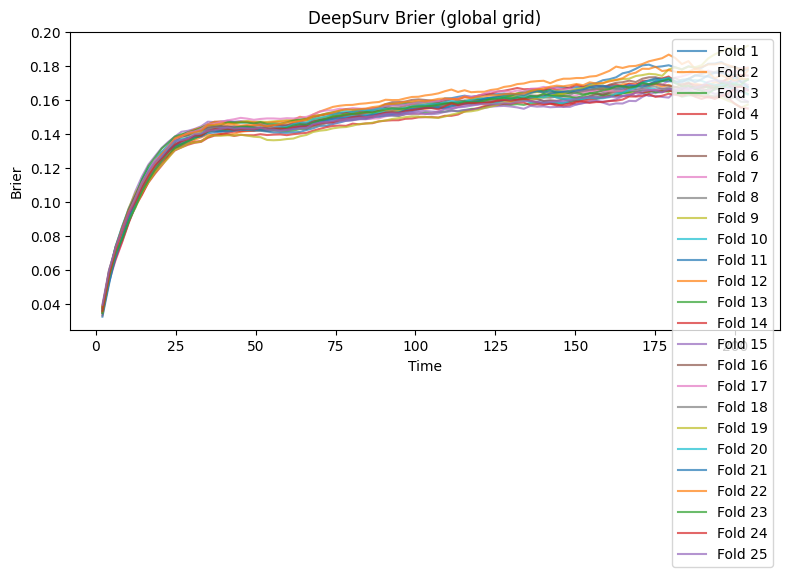

In [ ]:
# -------------------
# 2. 최종 평가 & 저장/플롯 (RepeatedKFold)
# -------------------
best_params = best.params  # 위에서 얻은 best(Optuna trial)의 params 사용
lr_f   = best_params["lr"]
drop_f = best_params["dropout"]
act_f  = best_params["activation"]
act_fn = {"ReLU": nn.ReLU, "ELU": nn.ELU, "SELU": nn.SELU}[act_f]

rkf2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cidxs, ibss = [], []
times_set, brierset = [], []

# (선택) C-index를 고정 지평선에서 보고 싶으면 TAU 지정
TAU = float(np.quantile(durations, 0.90))

for fold, (tr, te) in enumerate(rkf2.split(x), start=1):
    x_tr, x_te = x[tr], x[te]
    d_tr, d_te = durations[tr], durations[te]
    e_tr, e_te = events[tr],    events[te]

    # 모델 초기화
    net = tt.practical.MLPVanilla(
        in_features, num_nodes, out_features,
        drop_f, activation=act_fn, output_bias=output_bias
    ).to(device)
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(lr_f)

    # Early stopping 권장 (Optuna 때와 동일한 전략)
    val_data = (x_te, (d_te, e_te))
    callbacks = [tt.callbacks.EarlyStopping(patience=10)]
    model.fit(x_tr, (d_tr, e_tr), batch_size=256, epochs=100,
              verbose=False, callbacks=callbacks, val_data=val_data)

    # 위험 점수
    r_te = model.predict(x_te).flatten()

    # sksurv용 structured labels
    st_tr = make_structured_array(d_tr, e_tr)
    st_te = make_structured_array(d_te, e_te)

    # C-index (IPCW)
    # 1) 전-시간 위험점수(로그-리스크)로
    cidx_all = concordance_index_ipcw(st_tr, st_te, r_te)[0]
    # 2) (선택) 고정 지평선 TAU에서 위험도로도 같이 보고 싶으면:
    # baseline/생존함수 예측을 아래에서 구한 뒤 risk_tau 계산해 별도 저장해도 됩니다.

    # ✅ baseline hazard: train 기반으로 명시적으로 추정
    model.compute_baseline_hazards(x_tr, (d_tr, e_tr))

    # 테스트셋 생존함수 예측 (index=이벤트 시점, columns=샘플)
    surv_df = model.predict_surv_df(x_te)

    # ✅ 전역 TIME_GRID로 보간 (앞/뒤 NaN도 채움)
    surv_interp = (surv_df
                   .reindex(TIME_GRID)
                   .interpolate(method="index")
                   .ffill()
                   .bfill())

    # ✅ 평가 가능한 공통 구간으로 제한(외삽 방지)
    tmax = float(min(d_tr.max(), d_te.max(), TIME_GRID.max()))
    mask = (surv_interp.index.values > 0) & (surv_interp.index.values <= tmax)
    times_eval = surv_interp.index.values[mask].astype(float)

    # sksurv 기대형상으로 변환: (n_test, n_times)
    surv_est = surv_interp.loc[times_eval].T.values.astype(float)

    # IBS
    ibs = float(integrated_brier_score(st_tr, st_te, surv_est, times_eval))
    ibss.append(ibs)

    # per-time Brier curve
    t_grid, brier = brier_score(st_tr, st_te, surv_est, times_eval)
    times_set.append(t_grid)
    brierset.append(brier)

    # (선택) TAU에서의 C-index: risk = 1 - S(TAU)
    idx_tau = int(np.argmin(np.abs(times_eval - TAU)))
    risk_tau = 1.0 - surv_est[:, idx_tau]
    cidx_tau = float(concordance_index_ipcw(st_tr, st_te, risk_tau, tau=TAU)[0])

    # 여기서는 전-시간 위험점수 C-index를 저장(또는 cidx_tau로 대체 가능)
    cidxs.append(cidx_all)

    print(f"Fold {fold}: C-index(all-time)={cidx_all:.4f}, C-index@{TAU:.1f}m={cidx_tau:.4f}, IBS={ibs:.4f}")

print("\nFinal:")
print(f"Avg C-index: {np.mean(cidxs):.4f} ± {np.std(cidxs):.4f}")
print(f"Avg IBS    : {np.mean(ibss):.4f} ± {np.std(ibss):.4f}")

best_i = int(np.argmin(ibss))
os.makedirs("./BS_results", exist_ok=True)
np.save("./BS_results/times.npy", times_set[best_i])
np.save("./BS_results/brier.npy",  brierset[best_i])
print(f"Saved best fold {best_i+1} curve.")

plt.figure(figsize=(8,5))
for i,(tg,bg) in enumerate(zip(times_set, brierset), 1):
    plt.plot(tg, bg, label=f"Fold {i}", alpha=0.7)
plt.xlabel("Time"); plt.ylabel("Brier")
plt.title("DeepSurv Brier (global grid)")
plt.legend(); plt.tight_layout(); plt.show()


### 최적 파라미터를 활용하여 얻은 Deepsurv 모델의 SHAP 값 도출

Using device: cuda
Fold 1: C-index=0.7702, IBS=0.1463
Fold 2: C-index=0.7284, IBS=0.1540
Fold 3: C-index=0.7505, IBS=0.1582
Fold 4: C-index=0.7726, IBS=0.1465
Fold 5: C-index=0.7739, IBS=0.1460
Fold 6: C-index=0.7630, IBS=0.1559
Fold 7: C-index=0.7481, IBS=0.1466
Fold 8: C-index=0.7675, IBS=0.1507
Fold 9: C-index=0.7653, IBS=0.1461
Fold 10: C-index=0.7613, IBS=0.1494
Fold 11: C-index=0.7720, IBS=0.1465
Fold 12: C-index=0.7340, IBS=0.1527
Fold 13: C-index=0.7615, IBS=0.1537
Fold 14: C-index=0.7647, IBS=0.1450
Fold 15: C-index=0.7615, IBS=0.1511
Fold 16: C-index=0.7540, IBS=0.1508
Fold 17: C-index=0.7761, IBS=0.1482
Fold 18: C-index=0.7552, IBS=0.1472
Fold 19: C-index=0.7697, IBS=0.1467
Fold 20: C-index=0.7562, IBS=0.1549
Fold 21: C-index=0.7609, IBS=0.1540
Fold 22: C-index=0.7735, IBS=0.1473
Fold 23: C-index=0.7312, IBS=0.1517
Fold 24: C-index=0.7676, IBS=0.1478
Fold 25: C-index=0.7676, IBS=0.1486

Final:
Avg C-index: 0.7603 ± 0.0129
Avg IBS    : 0.1498 ± 0.0036


  0%|          | 0/50 [00:00<?, ?it/s]

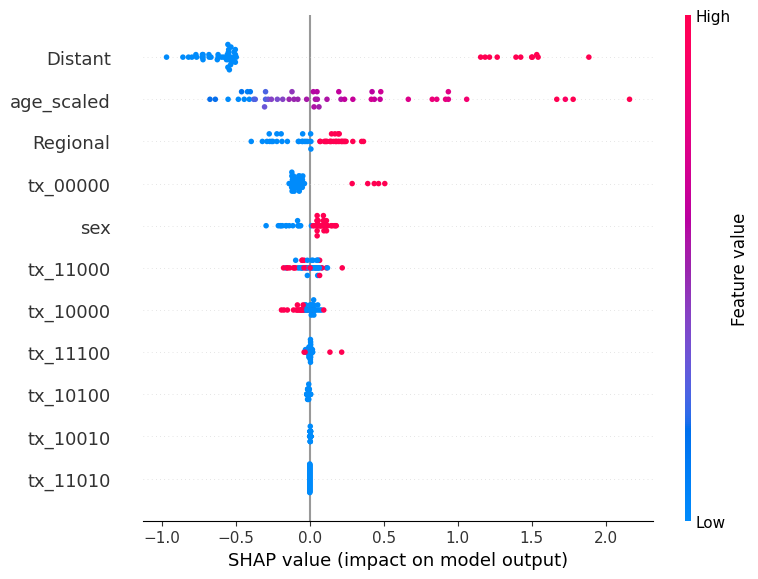

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import optuna
import shap
from sklearn.model_selection import RepeatedKFold
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score
)
import torchtuples as tt
from pycox.models import CoxPH
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------
# 데이터 로드 및 전처리
# -------------------
df = pd.read_csv(
    '/content/drive/MyDrive/생존분석 논문자료/graduation/data/colon_cancer.csv')


feature_cols = ['age_scaled','tx_10000', 'tx_10010', 'tx_10100', 'tx_11000', 'tx_11010', 'tx_11100',
         'Regional', 'Distant', 'sex','tx_00000']
time_col  = 'stime'
event_col = 'event_inc'

# sex가 object면 코드화
if df['sex'].dtype == object:
    df['sex'] = df['sex'].astype('category').cat.codes

x = df[feature_cols].values.astype('float32')
durations = df[time_col].values.astype('float32')
events    = df[event_col].values.astype('int32')

def make_structured_array(durations, events):
    return np.array(
        [(bool(e), t) for e, t in zip(events, durations)],
        dtype=[('event','?'), ('time','<f8')]
    )

# -------------------
# 네트워크 기본 설정 (architecture 고정)
# -------------------
in_features  = x.shape[1]
num_nodes    = [64,32,32,32,32,16]
out_features = 1
output_bias  = False

# -------------------
# 2. 최종 평가 & 저장/플롯 (RepeatedKFold)
# -------------------

# 최적 파라미터 수동 설정
#Params={'lr': 0.000869529852124947, 'dropout': 0.3896713646212832, 'activation': 'SELU'}
drop_f = 0.3896713646212832
lr_f = 0.000869529852124947
act_fn = nn.SELU

models = []  # 각 fold의 모델 저장
splits = []  # 각 fold의 train/test 인덱스 저장

# RepeatedKFold 객체 생성
rkf2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cidxs, ibss = [], []
times_set, brierset = [], []

# RepeatedKFold 반복 수행
for fold, (tr, te) in enumerate(rkf2.split(x), start=1):
    x_tr, x_te = x[tr], x[te]
    d_tr, d_te = durations[tr], durations[te]
    e_tr, e_te = events[tr], events[te]

    net = tt.practical.MLPVanilla(
        in_features, num_nodes, out_features,
        drop_f, activation=act_fn, output_bias=output_bias
    ).to(device)
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(lr_f)
    model.fit(x_tr,(d_tr,e_tr),batch_size=256,epochs=100,verbose=False)

    # 모델 저장
    models.append(model)
    splits.append((x_tr, x_te))

    r_tr = model.predict(x_tr).flatten()
    r_te = model.predict(x_te).flatten()
    st_tr = make_structured_array(d_tr,e_tr)
    st_te = make_structured_array(d_te,e_te)
    cidxs.append(concordance_index_ipcw(st_tr, st_te, r_te)[0])

    ordr = np.argsort(d_tr)
    t_o,e_o,r_o = d_tr[ordr],e_tr[ordr],r_tr[ordr]
    exp_r = np.exp(r_o)
    ut = np.unique(t_o[e_o==1])
    max_te = d_te.max()
    times = ut[ut<max_te]
    ch = np.zeros_like(times)
    for i,t0 in enumerate(times):
        ar = exp_r[t_o>=t0].sum()
        ne = (t_o[e_o==1]==t0).sum()
        ch[i] = (ch[i-1] if i>0 else 0) + ne/ar
    bs = np.exp(-ch)

    sp = np.vstack([np.power(bs,np.exp(r)) for r in r_te])
    ibss.append(integrated_brier_score(st_tr,st_te,sp,times))
    tg, bg = brier_score(st_tr,st_te,sp,times)
    times_set.append(tg); brierset.append(bg)

    print(f"Fold {fold}: C-index={cidxs[-1]:.4f}, IBS={ibss[-1]:.4f}")

print("\nFinal:")
print(f"Avg C-index: {np.mean(cidxs):.4f} ± {np.std(cidxs):.4f}")
print(f"Avg IBS    : {np.mean(ibss):.4f} ± {np.std(ibss):.4f}")

# RepeatedKFold 반복으로 학습시킨 모델들과 그 학습데이터들 중에서
# 가장 높은 성능의 모델과 해당 모델을 학습시키는데 사용된 학습데이터를 뽑아온다.
best_i = int(np.argmin(ibss))
model_best = models[best_i]
x_tr_best, x_te_best = splits[best_i]

# SHAP 도출
# Kernal Explainer 활용
# SHAP 분석용
model_best.net.eval()

def predict_fn(data):
    data_tensor = torch.from_numpy(data.astype('float32')).to(device)
    risk = model_best.predict(data_tensor).flatten().cpu().detach().numpy()
    return risk

explainer = shap.KernelExplainer(predict_fn, x_tr_best[:100])
shap_values = explainer.shap_values(x_te_best[:50])

# shap plot
shap.summary_plot(shap_values, x_te_best[:50], feature_names=feature_cols)

### 최적의 하이퍼파라미터를 활용해서 [64,32,32,16]레이어의 Deepsurv에 대한 Permutation importance 도출

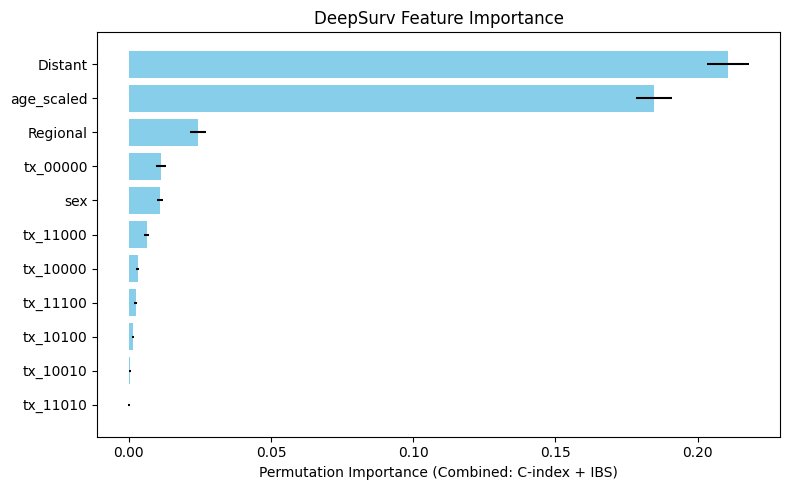

In [ ]:
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_ipcw, integrated_brier_score
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 💡 Step 1. best fold의 인덱스 복원 (rkf2 기반)
rkf2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
index_splits = list(rkf2.split(x))
train_idx_best, test_idx_best = index_splits[best_i]

X_train_best = x[train_idx_best]
X_test_best  = x[test_idx_best]

dur_train = durations[train_idx_best]
dur_test  = durations[test_idx_best]

evt_train = events[train_idx_best]
evt_test  = events[test_idx_best]

def make_structured_array(durations, events):
    return np.array([(bool(e), t) for e, t in zip(events, durations)],
                    dtype=[('event', '?'), ('time', '<f8')])

y_train_best_structured = make_structured_array(dur_train, evt_train)
y_test_best_structured  = make_structured_array(dur_test, evt_test)

def deepsurv_combined_score(model, X, y_test_structured):
    device = next(model.net.parameters()).device

    # 위험 점수 예측
    X_tensor = torch.from_numpy(X.astype('float32')).to(device)
    risk_scores = model.predict(X_tensor).flatten().cpu().detach().numpy()

    # C-index
    cindex = concordance_index_ipcw(y_train_best_structured, y_test_structured, risk_scores)[0]

    # 생존 확률 추정
    exp_r = np.exp(model.predict(torch.from_numpy(X_train_best.astype('float32')).to(device)).flatten().cpu().detach().numpy())
    t_o = dur_train[evt_train == 1]
    ut = np.unique(t_o)
    times = ut[ut < y_test_structured["time"].max()]
    ch = np.zeros_like(times)
    for i, t0 in enumerate(times):
        ar = exp_r[dur_train >= t0].sum()
        ne = (t_o == t0).sum()
        ch[i] = (ch[i-1] if i > 0 else 0) + ne / ar
    bs = np.exp(-ch)
    surv_pred = np.vstack([np.power(bs, np.exp(r)) for r in risk_scores])

    ibs = integrated_brier_score(y_train_best_structured, y_test_structured, surv_pred, times)

    return -(ibs - cindex)


result = permutation_importance(
    estimator=model_best,
    X=X_test_best.astype('float32'),
    y=y_test_best_structured,
    scoring=lambda m, X, y: deepsurv_combined_score(model_best, X, y),
    n_repeats=10,
    random_state=42
)

perm_df = pd.DataFrame({
    "feature": feature_cols,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values(by="importance_mean", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(perm_df['feature'], perm_df['importance_mean'], xerr=perm_df['importance_std'], color='skyblue')
plt.xlabel("Permutation Importance (Combined: C-index + IBS)")
plt.title("DeepSurv Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Practice


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import optuna

from sklearn.model_selection import RepeatedKFold
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score
)
import torchtuples as tt
from pycox.models import CoxPH
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------
# 데이터 로드 및 전처리
# -------------------
df = pd.read_csv(
    '/content/drive/MyDrive/생존분석 논문자료/graduation/data/colon_cancer.csv')

feature_cols = ['age_scaled','tx_00100', 'tx_01000','tx_01100','tx_10000',
                'tx_10010', 'tx_10100','tx_11000','tx_11010','tx_11100',
                'Regional', 'Distant', 'sex','tx_00000']
time_col  = 'stime'
event_col = 'event_inc'

# sex가 object면 코드화
if df['sex'].dtype == object:
    df['sex'] = df['sex'].astype('category').cat.codes

x = df[feature_cols].values.astype('float32')
durations = df[time_col].values.astype('float32')
events    = df[event_col].values.astype('int32')

def make_structured_array(durations, events):
    return np.array(
        [(bool(e), t) for e, t in zip(events, durations)],
        dtype=[('event','?'), ('time','<f8')]
    )

# -------------------
# 네트워크 기본 설정 (architecture 고정)
# -------------------
in_features  = x.shape[1]
num_nodes    = [64,32,32,32,32,16]
out_features = 1
output_bias  = False

activation = nn.SELU
drop = 0.3896713646212832
lr = 0.000869529852124947

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
ibs_list, cidx_list = [], []

for tr_idx, te_idx in rkf.split(x):
    x_tr, x_te = x[tr_idx], x[te_idx]
    d_tr, d_te = durations[tr_idx], durations[te_idx]
    e_tr, e_te = events[tr_idx], events[te_idx]

    # 모델 초기화
    net   = tt.practical.MLPVanilla(
                in_features, num_nodes, out_features,
                drop, activation=activation, output_bias=output_bias
            ).to(device)
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(lr)

    # 학습
    model.fit(x_tr, (d_tr, e_tr), batch_size=256, epochs=10, verbose=False)

    # 위험 점수 예측
    risk_tr = model.predict(x_tr).flatten()
    risk_te = model.predict(x_te).flatten()
    surv_tr = make_structured_array(d_tr, e_tr)
    surv_te = make_structured_array(d_te, e_te)

    # C-index
    cidx_list.append(concordance_index_ipcw(surv_tr, surv_te, risk_te)[0])
    c1 = concordance_index_ipcw(surv_tr, surv_te,  risk_te)[0]
    c2 = concordance_index_ipcw(surv_tr, surv_te, -risk_te)[0]
    print(c1, c2)   # 더 큰 쪽이 올바른 부호 해석

    # # Baseline 추정
    # order = np.argsort(d_tr)
    # t_ord, e_ord, r_ord = d_tr[order], e_tr[order], risk_tr[order]
    # exp_r = np.exp(r_ord)
    # ut = np.unique(t_ord[e_ord==1])
    # # test의 최대 추적 관찰 시간
    # max_te = d_te.max()
    # times = ut[ut < max_te]
    # cumhaz = np.zeros_like(times)
    # for i, t0 in enumerate(times):
    #     at_risk = exp_r[t_ord>=t0].sum()
    #     n_evt   = (t_ord[e_ord==1]==t0).sum()
    #     cumhaz[i] = (cumhaz[i-1] if i>0 else 0) + n_evt/at_risk
    # base_surv = np.exp(-cumhaz)

#     surv_probs = np.vstack([np.power(base_surv, np.exp(r)) for r in risk_te])

#     # IBS
#     ibs_list.append(integrated_brier_score(surv_tr, surv_te, surv_probs, times))


# print(ibs_list, cidx_list)

Using device: cuda
0.740762037867459 0.2592379621325401
0.759167538275792 0.24083246172420808
0.77854904191082 0.22145095808918436


KeyboardInterrupt: 

## SHAP

In [ ]:
pip install shap

### SHAP.KernelExplainer





In [ ]:
import shap
import torch

# 모델의 신경망(net)을 평가 모드로 전환합니다.
model.net.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# x_train과 x_test는 이미 numpy 배열로 준비되어 있다고 가정합니다.
x_train_tensor = torch.from_numpy(x_train).to(device)
x_test_tensor = torch.from_numpy(x_test).to(device)

# 배경 데이터로 x_train의 일부 (예: 100개 샘플)를 사용합니다.
background = x_train_tensor[:100]

# 예측 함수: 이제 predict() 메서드를 사용합니다.
def predict_fn(data):
    data_tensor = torch.from_numpy(data.astype('float32')).to(device)
    risk = model.predict(data_tensor).flatten().cpu().detach().numpy()
    return risk

# KernelExplainer 생성
explainer_kernel = shap.KernelExplainer(predict_fn, x_train[:100])

# x_test의 일부 샘플에 대해 SHAP 값 계산 (예: 50개 샘플)
x_test_sample = x_test[:50]
shap_values_kernel = explainer_kernel.shap_values(x_test_sample)

# SHAP summary plot 그리기
feature_cols = ['tx_1', 'tx_2', 'tx_3', 'seer_TF', 'age', 'sex']
shap.summary_plot(shap_values_kernel, x_test_sample, feature_names=feature_cols)

## pycox의 Evalsurv 의 Concordance_td() 메서드를 활용한 평가
* Antoliny's C-index 활용 : time-dependent C-index
* 시간별로 예측된 생존함수에 대한 평가.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 데이터 로드: 사용자 데이터를 DataFrame으로 읽어옵니다.
df = pd.read_csv('/content/drive/MyDrive/생존분석 논문자료/final_data_v2.csv')

# 데이터 전처리
# 입력 변수: tx_1, tx_2, tx_3, seer_TF, age, sex
# 생존정보: stime (생존시간), event_inc (사건발생 여부)
feature_cols = ['tx_1', 'tx_2', 'tx_3', 'seer_TF', 'age', 'sex']
time_col = 'stime'
event_col = 'event_inc'

# 'sex' 컬럼이 문자열이면 인코딩
if df['sex'].dtype == object:
    df['sex'] = df['sex'].astype('category').cat.codes

# 연속형 변수 표준화 (예: age)
scaler = StandardScaler()
df['age'] = scaler.fit_transform(df[['age']])

# 입력 데이터와 생존 라벨 구성
x = df[feature_cols].values.astype('float32')
durations = df[time_col].values.astype('float32')
events = df[event_col].values.astype('int32')

# 학습 파라미터
batch_size = 256
num_epochs = 100
lr = 1e-3
verbose = False

# 네트워크 정의 (pycox 예제 스타일)
in_features = x.shape[1]
num_nodes = [64, 32]
out_features = 1
dropout = 0.2
# 인자 순서: (in_features, num_nodes, out_features, activation, dropout)
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, nn.ReLU(), dropout)

# 5-Fold 교차검증 준비
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cindex_scores = []
brier_scores = []
integrated_brier_scores = []
fold = 1

for train_index, test_index in kf.split(x):
    print(f"Fold {fold}...")
    fold += 1

    # 데이터 분할
    x_train, x_test = x[train_index], x[test_index]
    durations_train, durations_test = durations[train_index], durations[test_index]
    events_train, events_test = events[train_index], events[test_index]

    # pycox 모델 학습을 위한 라벨: (duration, event) 튜플
    y_train = (durations_train, events_train)
    y_test = (durations_test, events_test)

    # 각 fold마다 모델 초기화
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, nn.ReLU(), dropout)
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(lr)

    # 모델 학습 (train/validation split 없이 전체 훈련 데이터 사용)
    log = model.fit(x_train, y_train, batch_size, num_epochs, verbose=verbose)

    # 예측: 생존함수 DataFrame (행: 환자, 열: 예측 시간)
    surv = model.predict_surv_df(x_test)

    # EvalSurv 객체 생성 (censor_surv='km' 옵션은 KM 추정치를 이용한 검열분포 사용)
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

    # 평가 지표 계산
    c_index = ev.concordance_td('antolini')
    # 평가 시간은 예측 생존 함수의 인덱스(시간 포인트)를 사용
    times = surv.index.values
    brier = ev.brier_score(times).mean()  # 각 시간에서의 Brier score 평균값
    ibs = ev.integrated_brier_score(times)

    cindex_scores.append(c_index)
    brier_scores.append(brier)
    integrated_brier_scores.append(ibs)

    print(f"Fold Concordance-index: {c_index:.4f}, Average Brier Score: {brier:.4f}, Integrated Brier Score: {ibs:.4f}")

print(f"\nAverage Concordance-index: {np.mean(cindex_scores):.4f}")
print(f"Average Brier Score: {np.mean(brier_scores):.4f}")
print(f"Average Integrated Brier Score: {np.mean(integrated_brier_scores):.4f}")


## pycox 공식 문서 내용



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import pandas as pd

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(123)
print(_)

In [ ]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [ ]:
df_train.head()
df_test.head()
df_train.shape

In [ ]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
print(f'standardize\n {standardize}')

leave = [(col, None) for col in cols_leave]
print(f'leave \n {leave}')

x_mapper = DataFrameMapper(standardize + leave)
print(f'X_mapper \n {x_mapper}')

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [ ]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

print(y_train)

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)
net

In [ ]:
model = CoxPH(net, tt.optim.Adam)
model

batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

In [ ]:
model.optimizer.set_lr(0.01)

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

In [ ]:
_ = log.plot()

In [ ]:
model.partial_log_likelihood(*val).mean()
